In [1]:
from mlgrad.risk import ERisk, ERiskGB
from mlgrad.loss import SquareErrorLoss
from mlgrad.func import SoftPlus, Sqrt, Sigmoidal, HingeSqrt, Arctang

from mlgrad import erm_fg, erm_irgd, fg, erm_fg, erisk
from mlgrad.regr import m_regression_irls
from mlgrad.af import averaging_function
from mlgrad.weights import MWeights

import mlgrad.model as model

import numpy as np

In [2]:
import sklearn.datasets as datasets
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [3]:
_noise = 0.3
X, Y = datasets.make_moons(n_samples=200, noise=_noise, random_state=0)
N = len(X)
Y = 2.0*Y-1.0
print(X.shape, Y.shape)
print(X.dtype, Y.dtype)

# I1 = np.array([i for i in range(N) if Y[i] == 1])
# I2 = np.array([i for i in range(N) if Y[i] == -1])
# print(I1)
# print(I2)
# X1 = np.array([X[i,1] for i in I1])
# X2 = np.array([X[i,1] for i in I2])
# J1 = np.argsort(X1)
# J2 = np.argsort(X2)

# print(J1)
# print(J2)

(200, 2) (200,)
float64 float64


In [4]:
Y_o = np.array([y for y in Y])

In [5]:
# M=10
# for k in range(M//2):
#     j1 = J1[k]
#     i1 = I1[j1]
#     Y_o[i1] = -Y[i1]
# for k in range(M//2):
#     j2 = J2[-k-1]
#     i2 = I2[j2]
#     Y_o[i2] = -Y[i2]
# noise = M / 200
noise = _noise

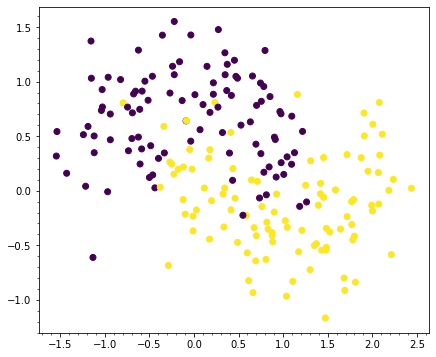

In [6]:
plt.figure(figsize=(7,6))
plt.scatter(X[:,0], X[:, 1], c=Y_o)
plt.minorticks_on()
plt.show()

In [7]:
from mlgrad.boost.gb_regression import gb_fit, gb_fit_agg

def new_model(n):
    mod = model.SigmaNeuronModel(Sigmoidal(), n)
    mod.init_param()
    return mod

m = 30

In [8]:
gb = gb_fit(X, Y_o, new_model, n_iter=m, n_iter2=22)
lfm, lvals = gb.complex_model, gb.lvals
print(np.asarray(lfm.weights))

[ 1.53563956  0.23567546  0.22897904 -0.03386225  0.02243601  0.02927818
  0.03629634  0.15489899  0.16653336  0.01073874  0.0132783   0.0255184
  0.0165189   0.03210382  0.02434148  0.05011649  0.06628951  0.06999282
  0.07011553  0.07006712  0.07007678  0.07011073  0.07006143  0.07010128
  0.0700335   0.07010009  0.07010308  0.07009179  0.12773834  0.09601268]


In [9]:
alpha=0.98
gb_agg = gb_fit_agg(X, Y_o, new_model, aggname='AM', alpha=alpha, n_iter=m, n_iter2=22)
lfm_agg, lvals_agg = gb_agg.complex_model, gb_agg.lvals
print(np.asarray(lfm_agg.weights))

[ 1.31005289e+00  2.23813918e-01  1.15544001e-01 -4.95586178e-03
 -7.10702052e-03 -4.21522796e-03 -2.98551857e-03 -1.23864664e-03
  1.17829296e-02  1.16276793e-02  7.90420119e-02  4.28523115e-02
  3.30485246e-02  3.38730682e-02  3.36272536e-02  1.31478579e-01
  1.09599292e-01  3.15516464e-02  6.47021959e-02  6.11943886e-02
  5.87637638e-02  5.77001569e-02  5.72484107e-02  5.71881732e-02
  5.71849768e-02  5.71963898e-02  5.71841725e-02  5.72087205e-02
  5.71865263e-02  5.71319322e-02]


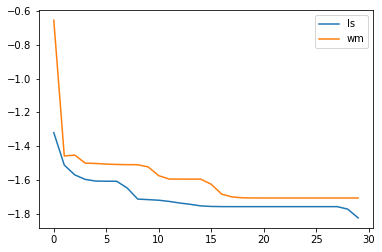

In [10]:
plt.plot(np.log(lvals), label='ls')
plt.plot(np.log(lvals_agg), label='wm')
plt.legend()
plt.show()

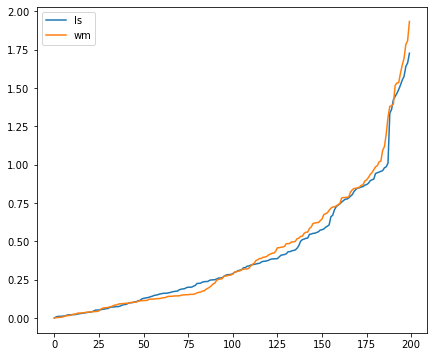

In [11]:
plt.figure(figsize=(7,6))
plt.plot(sorted([abs(lfm(X[k])-Y[k]) for k in range(len(X))]), label='ls')
plt.plot(sorted([abs(lfm_agg(X[k])-Y[k]) for k in range(len(X))]), label='wm')
plt.legend()
plt.show()

In [12]:
Y_ls = np.sign(lfm.evaluate_all(X))
Y_agg = np.sign(lfm_agg.evaluate_all(X))
acc_ls = 100*round(metrics.accuracy_score(Y_o, Y_ls), 3)
acc_wm = 100*round(metrics.accuracy_score(Y_o, Y_agg), 3)

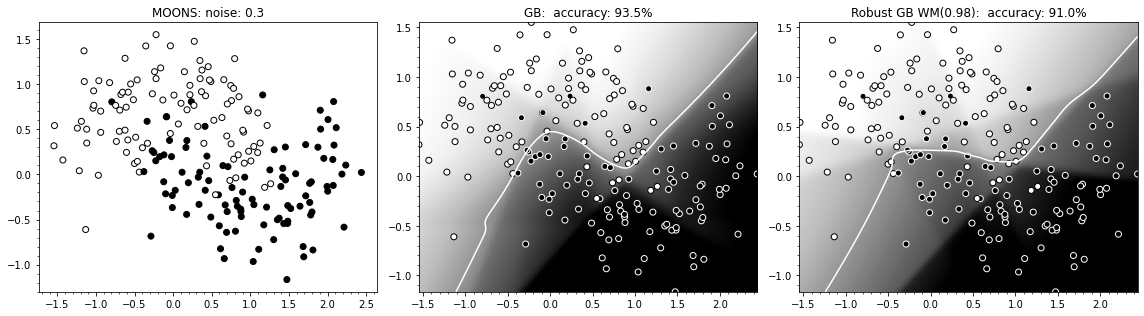

In [13]:
x_min, x_max = X[:,0].min(), X[:,0].max()
y_min, y_max = X[:,1].min(), X[:,1].max()
xrange = np.linspace(x_min, x_max, 100)
yrange = np.linspace(y_min, y_max, 100)
XX, YY = np.meshgrid(xrange, yrange)
X2 = np.c_[XX.ravel(), YY.ravel()]
Z2_ls = np.array([lfm(Xk) for Xk in X2])
Z2_agg = np.array([lfm_agg(Xk) for Xk in X2])
np.putmask(Z2_ls, Z2_ls > 1, 1) 
np.putmask(Z2_ls, Z2_ls < -1, -1) 
np.putmask(Z2_agg, Z2_agg > 1, 1) 
np.putmask(Z2_agg, Z2_agg < -1, -1) 
ZZ_ls = Z2_ls.reshape(XX.shape)
ZZ_agg = Z2_agg.reshape(XX.shape)

edgecolors = [('w' if y == 1.0 else 'k') for y in Y_o]

levels = [ 0.,]
plt.figure(figsize=(16,4.5))
plt.subplot(1,3,1)
plt.title("MOONS: noise: %.1f" % noise)
plt.scatter(X[:,0], X[:, 1], c=Y_o, edgecolors='k', cmap=plt.cm.Greys)
plt.minorticks_on()
plt.subplot(1,3,2)
plt.title("GB:  accuracy: %.1f%%" % (acc_ls))
plt.scatter(X[:,0], X[:, 1], c=Y_o, edgecolors=edgecolors, cmap=plt.cm.Greys)
cb = plt.imshow(ZZ_ls, aspect='auto', origin='lower', extent=(x_min,x_max,y_min,y_max), cmap=plt.cm.Greys)
cs = plt.contour(ZZ_ls, levels=levels, extent=(x_min,x_max,y_min,y_max), cmap=plt.cm.Greys)
# plt.clabel(cs, levels=levels)
# plt.colorbar(cb)
plt.minorticks_on()
plt.subplot(1,3,3)
plt.title("Robust GB WM(%.2f):  accuracy: %.1f%%" % (alpha, acc_wm))
plt.scatter(X[:,0], X[:, 1], c=Y_o, edgecolors=edgecolors, cmap=plt.cm.Greys)
cb = plt.imshow(ZZ_agg, aspect='auto', origin='lower', extent=(x_min,x_max,y_min,y_max), cmap=plt.cm.Greys)
cs = plt.contour(ZZ_agg, levels=levels, extent=(x_min,x_max,y_min,y_max), cmap=plt.cm.Greys)
# plt.clabel(cs, levels=levels)
# plt.colorbar(cb)
plt.minorticks_on()
plt.tight_layout()
plt.savefig('rob_gb_%.0f.eps' % round(noise*100))
plt.show()

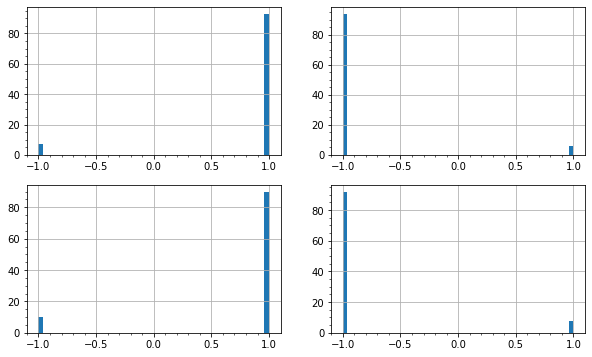

In [14]:
plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
plt.hist(Y_ls[Y_o == 1], bins=50)
plt.minorticks_on()
plt.grid(1)
plt.subplot(2,2,2)
plt.hist(Y_ls[Y_o == -1], bins=50)
plt.minorticks_on()
plt.grid(1)
plt.subplot(2,2,3)
plt.hist(Y_agg[Y_o == 1], bins=50)
plt.minorticks_on()
plt.grid(1)
plt.subplot(2,2,4)
plt.hist(Y_agg[Y_o == -1], bins=50)
plt.minorticks_on()
plt.grid(1)
plt.show()